In [1]:
import os
from pprint import pprint

from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re

In [2]:
ROOT_DIR = "~/aimers"
RANDOM_STATE = 42

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

# 모든 값이 동일할 때 컬럼을 제거
train_data = train_data.loc[:, (train_data != train_data.iloc[0]).any()]
test_data = test_data.loc[:, (test_data != test_data.iloc[0]).any()]

# 모든 값이 NAN인 열 제거
# train_data = train_data.dropna(axis=1, how='all')
# test_data = test_data.dropna(axis=1, how='all')
train_data.dropna(axis=1, inplace=True)
test_data.dropna(axis=1, inplace=True)


In [3]:
## 중복된 column 제거 ##
train_data = train_data.loc[:, ~train_data.T.duplicated()]

## speed 데이터가 밀린 것으로 보이는 column 제거 ##
train_data = train_data.drop(columns=['THICKNESS 1 Collect Result_Dam'])

In [4]:
import pandas as pd

# 설정할 피처 그룹
setting_feature_01 = [
    'CURE END POSITION X Collect Result_Dam', 'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam', 'CURE SPEED Collect Result_Dam',
    'CURE START POSITION X Collect Result_Dam', 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'HEAD Standby Position Y Collect Result_Dam', 'HEAD Standby Position Z Collect Result_Dam',
    'Head Clean Position X Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam', 'Head Purge Position X Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam', 'Head Zero Position X Collect Result_Dam',
    'Head Zero Position Y Collect Result_Dam', 'Head Zero Position Z Collect Result_Dam'
]
setting_feature_02 = [
    'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam', 'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam', 'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam'
]
setting_feature_03 = [
    'THICKNESS 3 Collect Result_Dam', 'WorkMode Collect Result_Dam',
    'Chamber Temp. Judge Value_AutoClave', 'HEAD Standby Position Y Collect Result_Fill1',
    'HEAD Standby Position Z Collect Result_Fill1', 'Head Clean Position X Collect Result_Fill1',
    'Head Clean Position Y Collect Result_Fill1', 'Head Clean Position Z Collect Result_Fill1',
    'Head Purge Position Z Collect Result_Fill1', 'WorkMode Collect Result_Fill1'
]
setting_feature_04 = [
    'CURE END POSITION X Collect Result_Fill2', 'CURE END POSITION Z Collect Result_Fill2',
    'CURE SPEED Collect Result_Fill2', 'CURE STANDBY POSITION Z Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2', 'HEAD Standby Position X Collect Result_Fill2', 
    'HEAD Standby Position Y Collect Result_Fill2',
    'HEAD Standby Position Z Collect Result_Fill2', 'Head Clean Position X Collect Result_Fill2',
    'Head Clean Position Y Collect Result_Fill2', 'Head Clean Position Z Collect Result_Fill2',
    'Head Purge Position X Collect Result_Fill2', 'Head Purge Position Z Collect Result_Fill2'
]
setting_feature_05 = [
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'
    ,'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'
    ,'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam', 'HEAD Standby Position X Collect Result_Dam'
]
setting_feature_06 = [
        'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1','HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'
]
setting_feature_07 = [
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2','HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2', 
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'
]
    
# 'setting' 피처 생성
train_data['setting1'] = train_data[setting_feature_01].astype(str).agg('-'.join, axis=1)
train_data['setting2'] = train_data[setting_feature_02].astype(str).agg('-'.join, axis=1)
train_data['setting3'] = train_data[setting_feature_03].astype(str).agg('-'.join, axis=1)
train_data['setting4'] = train_data[setting_feature_04].astype(str).agg('-'.join, axis=1)
train_data['setting5'] = train_data[setting_feature_05].astype(str).agg('-'.join, axis=1)
train_data['setting6'] = train_data[setting_feature_06].astype(str).agg('-'.join, axis=1)
train_data['setting7'] = train_data[setting_feature_07].astype(str).agg('-'.join, axis=1)

# 제거할 피처 리스트 생성
to_drop = setting_feature_01 + setting_feature_02 + setting_feature_03 + setting_feature_04 + setting_feature_05 + setting_feature_06 + setting_feature_07


# 피처 제거
train_data.drop(columns=to_drop, axis=1, inplace=True)

# 결과 확인
train_data


,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,Machine Tact time Collect Result_Dam,...,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,setting1,setting2,setting3,setting4,setting5,setting6,setting7
0,Dam dispenser #1,AJX75334505,4F1XA938-1,14.9,8.4,14.7,1.04,0.58,1.02,265.00,...,127,1,Normal,240.0-2.5--90-100-1030-16-257-66-0.0-127.5-66....,1-5800-5800-5800-5600-5800-5300-5300-5300-5300...,0.0-0.0-OK-289-50-0.0-123.4-50.0-50-1,240-33-48-33-1020-243.7-270-50--10-119-50.0-91...,550.5-464.3-161.4-384.0-383.1-384.0-274.51-274.51,838.4-458.7-157.0-430.0-429.8-430.3-244.52-244.52,835.5-458.0-156.0-428.0-427.9-428.0-243.7
1,Dam dispenser #1,AJX75334505,3KPM0016-2,21.3,4.9,21.3,1.49,0.34,1.49,65.10,...,1,0,Normal,240.0-2.5--90-70-1030-10-66-0-127.5-66.0-130.8...,4000-4000-4000-4000-4000-9000-9000-9000-9000-9...,0.0-7.0-OK-50-0-123.4-50.0-92.2-145-7,240-33-50-33-1020-270.0-50--10-119-50-91.8-270...,463.8-160.8-377.3-377.3-377.3-282.15-282.15-257.0,458.5-157.0-430.5-430.5-430.8-244.4-244.4-244.4,458.0-156.0-428.0-427.9-428.0-243.7-243.7
2,Dam dispenser #2,AJX75334501,4E1X9167-1,14.7,8.5,14.7,1.61,0.93,1.61,265.02,...,73,1,Normal,1000.0-12.5-90-85-280-16-257-66-0.0-127.5-66.0...,1-5800-5800-5800-5800-5800-5300-5300-5300-5300...,-0.022-0.003-OK-289-50-0.0-123.4-50.0-50-1,240-33-50-33-1020-243.5-270-50--10-119-50.0-91...,162.4-465.4-551.7-1271.8-1383.9-1271.8-274.33-...,837.9-458.1-156.1-1323.5-1322.5-1323.1-244.415...,305.0-499.8-694.0-1324.2-1324.2-1324.2-243.5
3,Dam dispenser #2,AJX75334501,3K1X0057-1,21.3,8.4,21.3,1.49,0.58,1.49,70.50,...,1,0,Normal,1000.0-12.5-90-70-280-10-66-0-127.5-66.0-130.8...,4000-4000-4000-4000-4000-5000-5000-5000-5000-5...,0.0-7.0-OK-50-0-123.4-50.0-92.2-145-7,240-33-50-33-1020-270.0-50--10-119-50-91.8-270...,465.5-552.0-1271.8-1270.7-1271.8-282.15-282.15...,458.8-157.0-1323.2-1322.5-1322.8-244.3-244.3-2...,499.8-694.0-1324.2-1324.2-1324.2-243.5-243.5
4,Dam dispenser #1,AJX75334501,3HPM0007-1,9.7,4.9,9.6,0.67,0.34,0.67,88.30,...,1,0,Normal,240.0-2.5--90-70-1030-10-66-0-127.5-66.0-133.5...,9000-9000-9000-9000-9000-9000-9000-9000-9000-9...,0.0-7.0-NG-50-0-123.4-50.0-92.2-85-7,240-32-50-33-1020-270.0-50--10-119-50-91.8-270...,462.5-159.5-377.5-377.0-377.5-284.8-284.8-257.0,458.5-157.0-430.2-430.5-430.5-244.4-244.4-244.4,458.0-156.0-428.0-427.9-428.0-243.7-243.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,17.0,5.0,17.0,1.19,0.35,1.19,56.70,...,1,0,Normal,240.0-2.5--90-70-1030-10-66-0-127.5-66.0-130.8...,5000-5000-5000-5000-5000-9000-9000-9000-9000-9...,0.0-7.0-OK-50-0-123.4-50.0-92.2-145-7,240-33-50-33-1020-270.0-50--10-119-50-91.8-270...,463.8-160.8-377.3-377.3-377.3-282.15-282.15-257.0,458.5-157.0-430.5-430.5-430.8-244.4-244.4-244.4,458.0-156.0-428.0-427.9-428.0-243.7-243.7
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,14.9,8.5,14.7,1.04,0.59,1.02,265.00,...,197,1,Normal,1000.0-12.5-90-100-280-16-257-66-0.0-127.5-66....,1-5800-5800-5800-5600-5800-5300-5300-5300-5300...,-0.021--0.118-NG-289-50-0.0-123.4-50.0-50-1,240-33-48-33-1020-243.5-270-50--10-119-50.0-91...,163.5-466.2-553.1-1281.0-1393.5-1281.2-274.33-...,838.1-458.7-156.1-1325.0-1324.0-1324.3-244.535...,304.8-499.8-692.8-1324.2-1324.2-1324.2-243.5
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,14.2,8.2,14.3,0.99,0.57,1.00,265.02,...,27,1,Normal,240.0-2.5--90-100-1030-16-257-66-0.0-127.5-66....,1-6000-6000-6000-6000-6000-5500-5500-5500-5500...,0.0-0.0-NG-289-50-0.0-123.4-50.0-50-1,240-33-50-33-1020-243.7-270-50--10-119-50.0-91...,550.6-463.9-161.5-377.6-377.1-378.0-274.78-274.78,838.4-458.4-157.0-430.8-430.5-431.1-244.543-24...,835.5-458.0-156.0-428.0-427.9-428.0-243.7
40

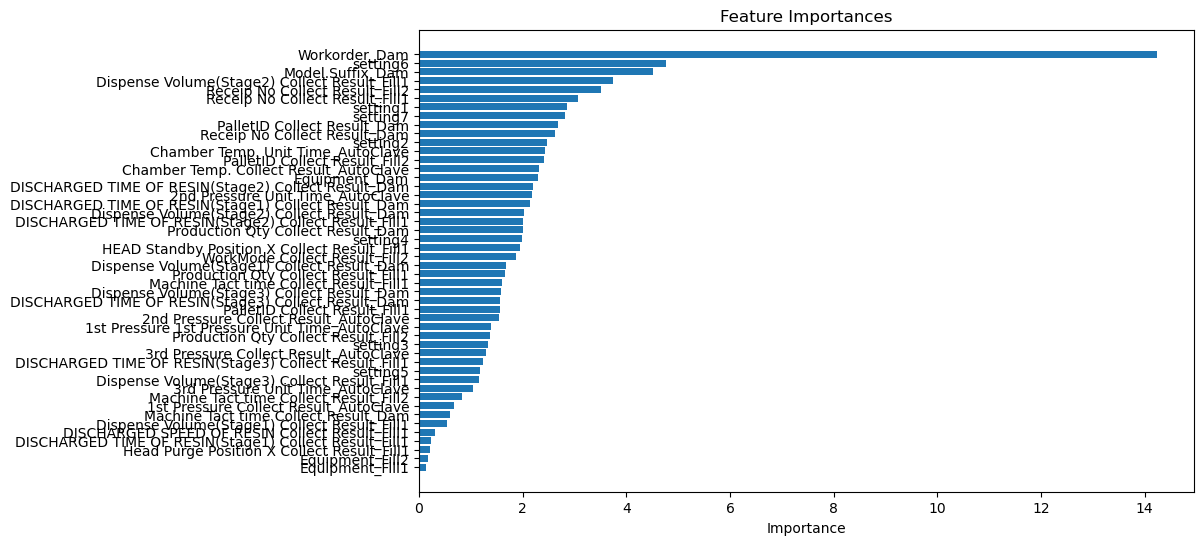

In [8]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 타겟 변수와 피처 변수 분리
X = train_data.drop(columns=['target'])  # 'target'이 타겟 변수라고 가정
y = train_data['target']

# CatBoost에서 범주형 변수로 처리할 피처 목록
cat_features = [col for col in X.columns if X[col].dtype == 'object']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CatBoostClassifier 모델 생성
model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=False)

# 모델 학습 (cat_features 파라미터 사용)
model.fit(X_train, y_train, cat_features=cat_features)

# 피처 중요도 계산
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# 피처 중요도를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.show()
